In [1]:
%load_ext autoreload
%autoreload 2
from common import *

In [2]:
RESULT_JSON = "/Users/law/repos/viper/results/latency_bw/latency_bw_all.json"

In [3]:
import json

results_raw = json.loads(open(RESULT_JSON).read())
BENCHMARKS =  results_raw["benchmarks"]

In [7]:
from collections import defaultdict

ALL_STORAGE_TYPES = ['dram', 'devdax', 'fsdax']
ALL_BM_TYPES = ['seq_read', 'rnd_read', 'seq_write', 'rnd_write', 'seq_grp_write', 'seq_off_write']

runs = {bmt: defaultdict(list) for bmt in ALL_BM_TYPES}
        
def get_bm_type(bm_type_str):
    for bmt in ALL_BM_TYPES:
        if bmt in bm_type_str:
            return bmt
    raise RuntimeError(f"Unknown bm_type: {bm_type_str}")
    
def get_storage_type(storage_str):
    for st in ALL_STORAGE_TYPES:
        if st in storage_str:
            return st
    raise RuntimeError(f"Unknown bm_type: {storage_str}")

for bm in BENCHMARKS:
    for storage_type in ALL_STORAGE_TYPES:
        if storage_type in bm['label']:
            bmt = get_bm_type(bm['label'])
            runs[bmt][storage_type].append(bm)
            break

In [249]:
FS=24
PLOT_TYPES = ['dram', 'devdax']

s2c = {'dram': "#990000", 'devdax': "#404040", 'fsdax': '#000099'}
grp2l = {1: '-.', 4: '--', 8: ':', 16: (0, (1, 1, 1, 0, 0, 0)), 32: '-'}

def _plot_basic(data, ax):
    for storage_type in PLOT_TYPES:
        if storage_type not in data:
            continue
        entries = data[storage_type][1:]
        threads = list(e['threads'] for e in entries)
        latencies = list(e['avg_latency_ns'] for e in entries) 
        ax.plot(threads, latencies, color=s2c[storage_type])
        
def _plot_prefault(data, ax, print_no_pre):
    for storage_type in PLOT_TYPES:
        if storage_type not in data:
            continue
        entries = data[storage_type]
        prefault = [e for e in entries if "-prefault" in e['label']]
        no_prefault = [e for e in entries if "no_prefault" in e['label']]
        
        entries_to_plot = [(prefault, True)]
        if print_no_pre:
            entries_to_plot.append((no_prefault, False))
        
        for (es, did_pre) in entries_to_plot:
            if not es:
                continue
            threads = list(e['threads'] for e in es)
            latencies = list(e['avg_latency_ns'] for e in es)
            label = f"{get_storage_type(es[0]['label'])} {'pre' if did_pre else 'no-pre'}"
            ax.plot(threads, latencies, label=label, 
                    color=s2c[storage_type], linestyle=pre2l[did_pre])      
        
def plot_seq_read(data, ax):
    ax.set_title("Sequential Read", fontsize=FS)
    _plot_basic(data, ax)

def plot_rnd_read(data, ax):
    ax.set_title("Random Read", fontsize=FS)
    _plot_basic(data, ax)

def plot_seq_write(data, ax, print_no_pre):
    ax.set_title("Sequential Write", fontsize=FS)
    _plot_prefault(data, ax, print_no_pre)        

def plot_rnd_write(data, ax, print_no_pre):
    ax.set_title("Random Write", fontsize=FS)
    _plot_prefault(data, ax, print_no_pre)   
    
def plot_seq_write_group(data, grp_to_ax, print_no_pre):
    for storage_type in PLOT_TYPES:
        entries = data[storage_type]
        prefault = [e for e in entries if "-prefault" in e['label']]
        no_prefault = [e for e in entries if "no_prefault" in e['label']]
        all_write_groups = [1, 4, 8, 16, 32]
        write_groups = defaultdict(list)
        for es, did_pre in [(prefault, True), (no_prefault, False)]:
            for e in es:
                for write_grp in all_write_groups:
                    if e['label'].endswith(f"grp_write_{write_grp}"):
                        write_groups[(write_grp, did_pre)].append(e)
        
        for (wg, did_pre) in sorted(write_groups.keys()):
            entries = {storage_type: write_groups[(wg, did_pre)]}
            _plot_prefault(entries, grp_to_ax[wg], print_no_pre) 
            
def plot_seq_write_group_1_plot(data, ax):
    write_groups = defaultdict(list)
    for storage_type in PLOT_TYPES:
        entries = data[storage_type]
        entries = [e for e in entries if "-prefault" in e['label']]
        all_write_groups = [1, 4, 8, 16, 32] if storage_type == 'devdax' else [1]
        for e in entries:
            for write_grp in all_write_groups:
                if e['label'].endswith(f"grp_write_{write_grp}"):
                    write_groups[(write_grp, storage_type)].append(e)
        
    for (wg, st) in sorted(write_groups.keys()):
        entries = write_groups[(wg, st)]
        threads = list(e['threads'] for e in entries)
        latencies = list(e['avg_latency_ns'] for e in entries)
        label = f"{wg}"
        ax.plot(threads, latencies, label=label, 
                color=s2c[st], linestyle=grp2l[wg] if st == 'devdax' else '-')
    
#     ax.text( 6, 250,  '1', fontsize=FS)
#     ax.text(14, 200, ' 4', fontsize=FS)
#     ax.text(28, 500,  '8', fontsize=FS)
#     ax.text(24, 250, '16', fontsize=FS)
#     ax.text(30, 140, '32', fontsize=FS)

def plot_seq_write_offset(data, ax):
    storage_type ='devdax'
    entries = data[storage_type]
    all_offsets = [0, 1024, 2048, 3072]
    offset_groups = defaultdict(list)
    for e in entries:
        for write_off in all_offsets:
            if e['label'].endswith(f"off_write_{write_off}"):
                offset_groups[write_off].append(e)

    data_points = []
    for off in sorted(offset_groups.keys()):
        entries = offset_groups[off]
        data_points.append(list(e['avg_latency_ns'] for e in entries)[-1]) 

    ax.bar([0, 1, 2, 3], data_points, color=s2c[storage_type])
    for i, v in enumerate(data_points):
        ax.text(i, v - 50, str(int(v)), fontsize=FS, color='white', ha='center')

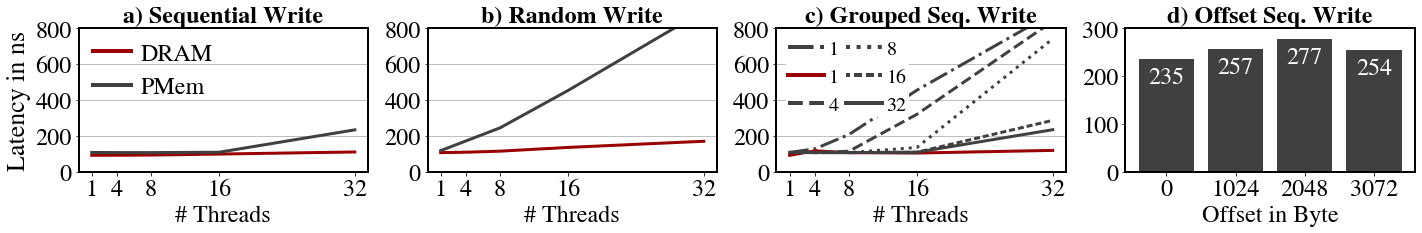

In [279]:
fig, axes = plt.subplots(1, 4, figsize=(20, 3.5))
(seq_ax, rnd_ax, grp_ax, off_ax) = axes

PRINT_NO_PRE = False
plot_seq_write(runs['seq_write'], seq_ax, PRINT_NO_PRE)
plot_rnd_write(runs['rnd_write'], rnd_ax, PRINT_NO_PRE)
plot_seq_write_group_1_plot(runs['seq_grp_write'], grp_ax)
plot_seq_write_offset(runs['seq_off_write'], off_ax)

for ax in axes:
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FS)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(FS)
        
for ax in (seq_ax, rnd_ax, grp_ax):
    ax.set_xlabel("# Threads", fontsize=FS)
    ax.set_ylim(0, 800)
    ax.set_xticks([1, 4, 8, 16, 32])
    ax.grid(axis='y', which='major')

off_ax.set_ylim(0, 300)
off_ax.set_xticks([0, 1, 2, 3])
off_ax.set_xticklabels([0, 1024, 2048, 3072])
off_ax.set_title("Offset Seq. Write", fontsize=FS)
off_ax.set_xlabel("Offset in Byte", fontsize=FS)

seq_ax.set_title("a) Sequential Write", fontsize=FS, fontweight='bold')
rnd_ax.set_title("b) Random Write", fontsize=FS, fontweight='bold')
grp_ax.set_title("c) Grouped Seq. Write", fontsize=FS, fontweight='bold')
off_ax.set_title("d) Offset Seq. Write", fontsize=FS, fontweight='bold')

seq_ax.set_ylabel("Latency in ns", fontsize=FS + 2)
# off_ax.set_ylabel("Latency in ns", fontsize=FS)

grp_leg = grp_ax.legend(fontsize=20, loc='upper left', ncol=2, frameon=True, edgecolor='white',
                        columnspacing=0.4, handletextpad=0.2, borderpad=0.1, 
                        handlelength=1.8, facecolor='white', framealpha=1)

seq_leg = seq_ax.legend(labels=['DRAM', "PMem"], fontsize=FS, loc='upper left', frameon=False,
                        handletextpad=0.4, borderpad=0.1, handlelength=1.6)

for legobj in (*seq_leg.legendHandles, *grp_leg.legendHandles):
    legobj.set_linewidth(4.0)
    
# fig.savefig('charts/design_latency.pdf', bbox_inches='tight')
# fig.savefig('charts/design_latency.svg', bbox_inches='tight')

## GENERAL OVERVIEW. NOT FOR PAPER PLOT!

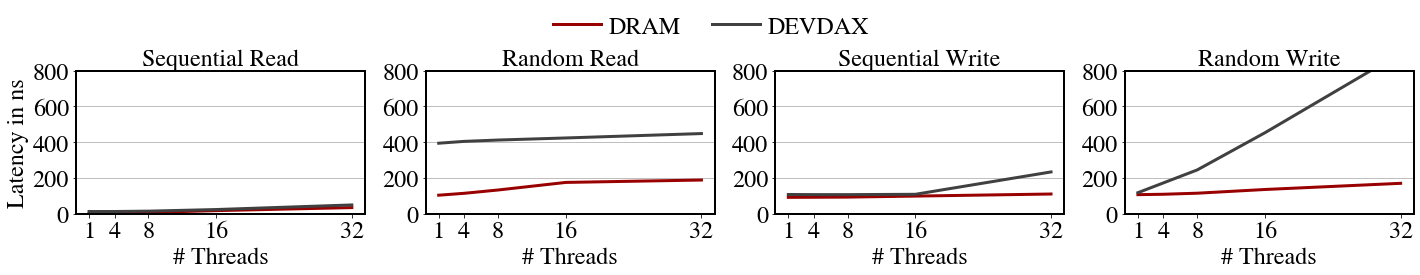

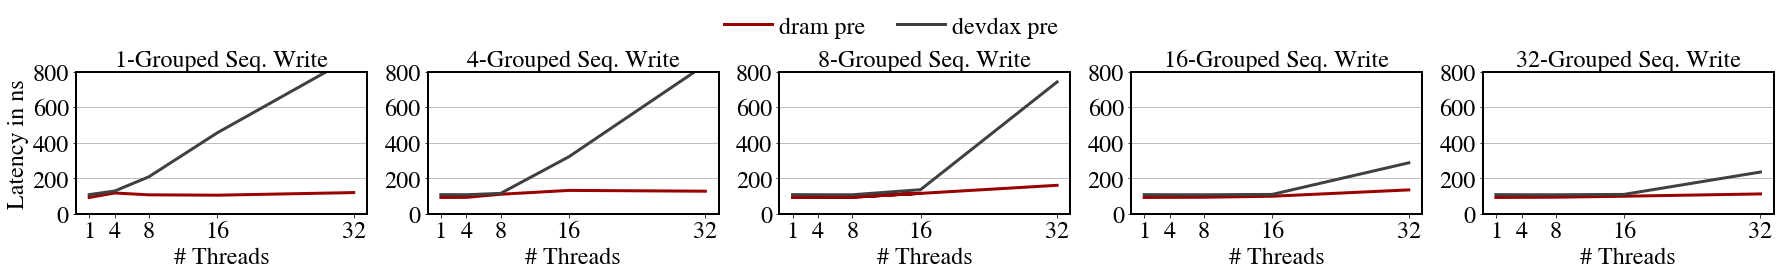

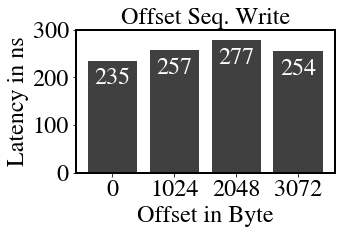

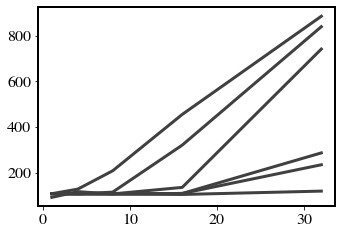

In [91]:

fig, axes = plt.subplots(1, 4, figsize=(20, 3.5))
(seq_read_ax, rnd_read_ax, seq_write_ax, rnd_write_ax) = axes

grp_fig, grp_axes = plt.subplots(1, 5, figsize=(25, 3.5))
(grp1_ax, grp4_ax, grp8_ax, grp16_ax, grp32_ax) = grp_axes
grp_to_ax = {1: grp1_ax, 4: grp4_ax, 8: grp8_ax, 16: grp16_ax, 32: grp32_ax}

off_fig, off_ax = plt.subplots(1, 1, figsize=(5, 3.5))

grp_test_fig, grp_test_ax = plt.subplots(1, 1, figsize=(5, 3.5))
plot_seq_write_group_1_plot(runs['seq_grp_write'], grp_test_ax)

PRINT_NO_PRE = False
plot_seq_read(runs['seq_read'], seq_read_ax)
plot_rnd_read(runs['rnd_read'], rnd_read_ax)
plot_seq_write(runs['seq_write'], seq_write_ax, PRINT_NO_PRE)
plot_rnd_write(runs['rnd_write'], rnd_write_ax, PRINT_NO_PRE)

plot_seq_write_offset(runs['seq_off_write'], off_ax)

PRINT_NO_PRE = False
plot_seq_write_group(runs['seq_grp_write'], grp_to_ax, PRINT_NO_PRE)

for ax in (*axes, *grp_axes, off_ax):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(FS)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(FS)
        
for ax in (*axes, *grp_axes):
    ax.set_xlabel("# Threads", fontsize=FS)
    ax.set_ylim(0, 800)
    ax.set_xticks([1, 4, 8, 16, 32])
    ax.grid(axis='y', which='major')

off_ax.set_ylim(0, 300)
off_ax.set_xticks([0, 1, 2, 3])
off_ax.set_xticklabels([0, 1024, 2048, 3072])
off_ax.set_title("Offset Seq. Write", fontsize=FS)
off_ax.set_xlabel("Offset in Byte", fontsize=FS)

for ax in [axes, grp_axes, [off_ax]]:
    ax[0].set_ylabel("Latency in ns", fontsize=FS)
    
fig.legend(labels=[l.upper() for l in PLOT_TYPES], fontsize=FS,
    loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6, frameon=False,
    columnspacing=1.3, handletextpad=0.3)
    
_, grp_labels = grp_axes[0].get_legend_handles_labels() 
grp_fig.legend(labels=grp_labels, fontsize=FS,
    loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=6, frameon=False,
    columnspacing=1.3, handletextpad=0.3)
                
for (wg, ax) in grp_to_ax.items():
    ax.set_title(f"{wg}-Grouped Seq. Write", fontsize=FS)

    
# fig.savefig('charts/latency_bw.pdf', bbox_inches='tight')
# fig.savefig('charts/latency_bw.svg', bbox_inches='tight')
# grp_fig.savefig('charts/grp_latency_bw.pdf', bbox_inches='tight')
# grp_fig.savefig('charts/grp_latency_bw.svg', bbox_inches='tight')
    
# fig.savefig('charts/latency_bw_prefault.pdf', bbox_inches='tight')
# fig.savefig('charts/latency_bw_prefault.svg', bbox_inches='tight')
# grp_fig.savefig('charts/grp_latency_bw_prefault.pdf', bbox_inches='tight')
# grp_fig.savefig('charts/grp_latency_bw_prefault.svg', bbox_inches='tight')